# RNN - Convolución simple

* 2 capas de convolución + ReLU + MaxPooling
* 2 capas totalmente conectadas

## Carga de libreiras e inicio de session

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1.keras import datasets
from tensorflow.python.framework import ops

ops.reset_default_graph()
session = tf.compat.v1.Session()

## Carga de dataset - MNIST

In [174]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

def normalize(m):
    max = 255
    min = 0
    return (m)/(max-min)

x_train = normalize(x_train)
x_test = normalize(x_test)

## Variables para la RNN

In [175]:
# Alto, ancho y numero de canales de las imaganes
image_height = x_train[0].shape[0]
image_width = x_train[0].shape[0]
num_channels = 1

# Nodos por convolucion
convl1_features = 64
convl2_features = 128

# Tmaño de max_pool
max_pool_size1 = 2
max_pool_size2 = 2

# Nodos totalmente conectados
full_conected_size = 100

# Numero de categorias
target_size = max(y_test)+1

# Numero de muestras por entrenamiento
batch_size = 50

# Radio de aprendizaje y momentum
learning_rate = 0.001
momentum = 0.9

# Generaciones de aprendizaje
generations = 1000

# Numero de generaciones por evaluacion
eval_every = 10
# Numero de muestras por evaluacion
evaluation_size = 250

## TF.Placeholders - Datos que suministraremos a la red

In [176]:
x_input_shape = (batch_size, image_height, image_width, num_channels)
x_input = tf.compat.v1.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.compat.v1.placeholder(tf.int32, shape = (batch_size))

eval_input_shape = (evaluation_size, image_height, image_width, num_channels)
eval_input = tf.compat.v1.placeholder(tf.float32, shape = eval_input_shape)
eval_target = tf.compat.v1.placeholder(tf.int32, shape = (evaluation_size))

## TF.Variables
### Variables para la convolución

In [177]:
convl1_w = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[4,4,num_channels,convl1_features], stddev=0.1, dtype=tf.float32))
convl1_b = tf.compat.v1.Variable(tf.zeros(shape=[convl1_features], dtype=tf.float32))

convl2_w = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[4,4,convl1_features,convl2_features], stddev=0.1, dtype=tf.float32))
convl2_b = tf.compat.v1.Variable(tf.zeros(shape=[convl2_features], dtype=tf.float32))

### Variables de la capa totalmente conectada

In [178]:
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)

full_input_size = (resulting_width*resulting_height*convl2_features)
full1_w = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[full_input_size, full_conected_size], stddev=0.1, dtype=tf.float32))
full1_b = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[full_conected_size], stddev=0.1, dtype=tf.float32))

full2_w = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[full_conected_size, target_size], stddev=0.1, dtype=tf.float32))
full2_b = tf.compat.v1.Variable(tf.random.truncated_normal(shape=[target_size], stddev=0.1, dtype=tf.float32))


## Creación de la función del Modelo

In [179]:
def conv_NN(input_data):
    # Primera capa - Primer convolucion + ReLU + MaxPooling
    conv1 = tf.nn.conv2d(input_data,convl1_w, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, convl1_b))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1,max_pool_size2,1], strides=[1,max_pool_size1,max_pool_size2,1], padding="SAME")
    
    # Segunda capa - Segunda convolucion + ReLU + MaxPooling
    conv2 = tf.nn.conv2d(max_pool1,convl2_w, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, convl2_b))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size1,max_pool_size2,1], strides=[1,max_pool_size1,max_pool_size2,1], padding="SAME")
    
    
    # Operación flattening para aplanar la imagen en un vector
    final_conv2_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv2_shape[1]*final_conv2_shape[2]*final_conv2_shape[3]
    flat_output = tf.reshape(max_pool2, shape=[final_conv2_shape[0],final_shape])
    
    # Tercer capa - Primer capa Fully Conected
    fully_conected1 = tf.nn.relu(tf.add(tf.matmul(flat_output,full1_w),full1_b))
    
    # Cuarta capa - Segunda capa Fully Conected
    fully_conected2 = tf.nn.relu(tf.add(tf.matmul(fully_conected1,full2_w),full2_b))
    
    # Return - Resultado de la red neuronal
    return fully_conected2

## Creación de los objetos del modelo

In [180]:
model_output = conv_NN(x_input)
test_model_output = conv_NN(eval_input)

## Función de perdida

In [181]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

## Creación de la función de predicción de entrenamiento y de test

In [182]:
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

## Calculo de la precisión

In [183]:
def get_accuracy(logits,targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_corrects = np.sum(np.equal(batch_predictions,targets))
    return 100.0*num_corrects/batch_predictions.shape[0]

## Función de optimización

In [184]:
my_optim = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate,momentum=momentum)
train_step = my_optim.minimize(loss)

## Inicialización de TF.Variables

In [185]:
init = tf.compat.v1.global_variables_initializer()
session.run(init)

## Entrenamiento del modelo

In [186]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []

for i in range(generations):
    # Id's de n imagenes, n -> batch_size
    rand_idx = np.random.choice(len(x_train), size=batch_size)
    # Se toman las imagenes a entrenar
    rand_x = x_train[rand_idx]
    # El formato en el que vienen los datos les falta la dimesión de los canales de colores
    # Se expande la dimensión para los canales de colores
    # Recordemos que este dataset son imagenes de un solo canal, en grises
    rand_x = np.expand_dims(rand_x, 3)
    # Tomar los valores objetivos de cada imagen tomada para entrenar
    rand_y = y_train[rand_idx]
    
    # Diccionario de datos a entrenar
    train_dic = {x_input:rand_x,y_target:rand_y}
    
    # Ejecutar un paso del entrenamiento
    session.run(train_step,feed_dict=train_dic)
    
    """Dado que se guardaran en el arreglo cada 20 pasos, mejor se consulta antes de guardarlo y no cada paso"""
    # Valor de perdida y de presision
    #temp_train_loss, temp_train_preds = session.run([loss,prediction],feed_dict=train_dic)
    #temp_train_acc = get_accuracy(temp_train_preds,rand_y)
    
    # Evaluación del modelo contra test
    if (i+1) % eval_every == 0:
        # Id's de n imagenes test, n -> evaluation_size
        rand_idx_test = np.random.choice(len(x_test), size=evaluation_size)
        # Se toman las imagenes test
        rand_x_test = x_test[rand_idx_test]
        rand_x_test = np.expand_dims(rand_x_test, 3)
        # Tomar los valores objetivos de cada imagen test tomada
        rand_y_test = y_test[rand_idx_test]
        
        # Diccionario de datos test
        train_dic_test = {eval_input:rand_x_test,eval_target:rand_y_test}
        
        """Optimización de no cargar 20 veces sin usar las variables"""
        # Valor de perdida y de presision
        temp_train_loss, temp_train_preds = session.run([loss,prediction],feed_dict=train_dic)
        temp_train_acc = get_accuracy(temp_train_preds,rand_y)
        
        # Presision del modelo contra test
        temp_test_preds = session.run(test_prediction,feed_dict=train_dic_test)
        temp_test_acc = get_accuracy(temp_test_preds,rand_y_test)
        
        i_vals.append(i+1)
        test_acc.append(temp_test_acc)
        train_acc.append(temp_train_acc)
        train_loss.append(temp_train_loss)
        
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteración {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteración 10. Train Loss: 2.304. Train Acc: 16.000. Test Acc: 19.600
Iteración 20. Train Loss: 2.319. Train Acc: 8.000. Test Acc: 19.600
Iteración 30. Train Loss: 2.104. Train Acc: 28.000. Test Acc: 23.600
Iteración 40. Train Loss: 1.989. Train Acc: 28.000. Test Acc: 27.600
Iteración 50. Train Loss: 2.104. Train Acc: 22.000. Test Acc: 29.200
Iteración 60. Train Loss: 1.961. Train Acc: 30.000. Test Acc: 31.200
Iteración 70. Train Loss: 1.847. Train Acc: 36.000. Test Acc: 36.400
Iteración 80. Train Loss: 1.625. Train Acc: 52.000. Test Acc: 34.800
Iteración 90. Train Loss: 1.622. Train Acc: 40.000. Test Acc: 32.800
Iteración 100. Train Loss: 1.721. Train Acc: 40.000. Test Acc: 40.000
Iteración 110. Train Loss: 1.693. Train Acc: 44.000. Test Acc: 37.600
Iteración 120. Train Loss: 1.688. Train Acc: 40.000. Test Acc: 43.600
Iteración 130. Train Loss: 1.551. Train Acc: 52.000. Test Acc: 44.000
Iteración 140. Train Loss: 1.718. Train Acc: 44.000. Test Acc: 42.400
Iteración 150. Train Loss: 1.5

## Grafica de perdidas y presisión del modelo

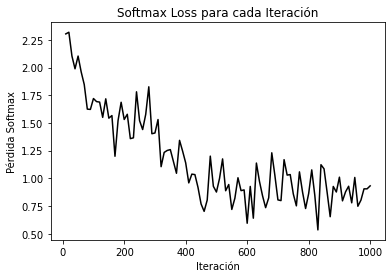

In [187]:
plt.plot(i_vals, train_loss, 'k-')
plt.title("Softmax Loss para cada Iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida Softmax")
plt.show()

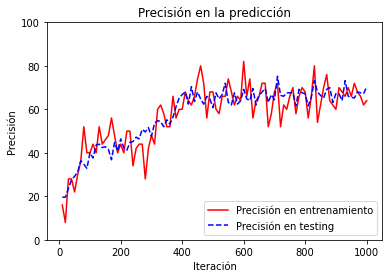

In [188]:
plt.plot(i_vals, train_acc, 'r-', label="Precisión en entrenamiento")
plt.plot(i_vals, test_acc, 'b--', label="Precisión en testing")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.ylim([0,100])
plt.title("Precisión en la predicción")
plt.legend(loc="lower right")
plt.show()

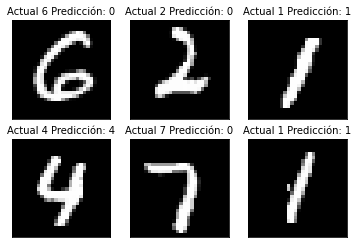

In [189]:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds, axis=1)[0:6]
images = np.squeeze(rand_x[0:6])
nrows = 2
ncols = 3
for i in range(6):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap="Greys_r")
    plt.title("Actual "+str(actuals[i])+" Predicción: "+str(predictions[i]), fontsize = 10)
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)